# Machine learning for Power System Stability Analysis

<p style="background-color:azure;padding:10px;border:2px solid lightsteelblue"><b>Author:</b> Petar Sarajcev, PhD (petar.sarajcev@fesb.hr)
<br>
University of Split, FESB, Department of Power Engineering <br>R. Boskovica 32, HR-21000 Split, Croatia, EU.</p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy import stats

In [3]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion

In [4]:
# Inline figures
%matplotlib inline

In [5]:
# Figure aesthetics
sns.set(context='notebook', style='white', font_scale=1.2)
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})

In [6]:
# ancilary function from: https://github.com/amueller/introduction_to_ml_with_python/blob/master/mglearn/tools.py
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", fontsize=14):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center", fontsize=fontsize)
    return img

### Transformer diagnostic data and health index values

In [7]:
data = pd.read_csv('GridDictionary.csv')
data.head()

,WmG1,WmG2,WmG3,WmG4,WmG5,WmG6,WmG7,WmG8,WmG9,WmG10,...,VClvB35,VAlvB36,VClvB36,VAlvB37,VClvB37,VAlvB38,VClvB38,VAlvB39,VClvB39,Stability
0,1.00120,1.0036,1.0029,1.0056,1.0079,1.0061,1.0060,1.0024,1.0025,1.0043,...,0.99777,1.03670,1.03670,1.0650,1.0650,1.0936,1.0936,1.0191,1.0191,0
1,1.00110,1.0033,1.0025,1.0047,1.0068,1.0052,1.0051,1.0021,1.0022,1.0039,...,1.01680,1.05330,1.05330,1.0673,1.0673,1.0922,1.0922,1.0192,1.0192,0
2,1.00120,1.0038,1.0033,1.0063,1.0079,1.0124,1.0114,1.0029,1.0030,1.0046,...,0.81049,0.88406,0.88378,1.0322,1.0322,1.0796,1.0796,1.0081,1.0081,0
3,1.00090,1.0025,1.0018,1.0011,1.0023,1.0015,1.0014,1.0012,1.0011,1.0020,...,1.07040,1.08570,1.08570,1.0570,1.0570,1.0676,1.0676,1.0252,1.0252,0
4,0.99983,1.0003,1.0007,1.0008,1.0008,1.0010,1.0009,1.0006,1.0010,1.0009,...,1.00710,1.01330,1.01330,1.0053,1.0053,1.0111,1.0111,1.0003,1.0003,0


In [8]:
# Percentage of "ones" in the "Stability" column
print('There is {:.1f}% of unstable cases in the dataset!'.format(data['Stability'].sum()/float(len(data['Stability']))*100.))

There is 19.1% of unstable cases in the dataset!


### Select a random subset of the original data

In [9]:
# Select a random subset of the original dataset (without replacement)
#SUBSET_SIZE = 2000
#random_idx = np.random.choice(data.index, size=SUBSET_SIZE, replace=False)
#data = data.iloc[random_idx]

### Data preprocessing and splitting

In [10]:
# Training dataset
no_features = len(data.columns) - 1
X_data = data.iloc[:,0:no_features]  # features
print('X_data', X_data.shape)
y_data = data['Stability']
print('y_data', y_data.shape)

X_data (3120, 276)
y_data (3120,)


In [11]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8, shuffle=True)

In [12]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (2496, 276)
y_train (2496,)
X_test (624, 276)
y_test (624,)


In [13]:
y_t = data[['Stability']].copy()
idx = y_test.index.values
y_t = y_t.loc[idx]
y_t.shape

(624, 1)

#### StandardScaler

In [14]:
# Standardize the input data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### LogisticRegression

In [15]:
# Logistic Regression (with fixed hyper-parameters)
lreg = LR(C=100.,  # fixed "C" hyper-parameter
          multi_class='ovr', solver='newton-cg', n_jobs=-1)
lreg.fit(X_train, y_train)  # fit model to data
y_lr = lreg.predict_proba(X_test)  # predict on new data

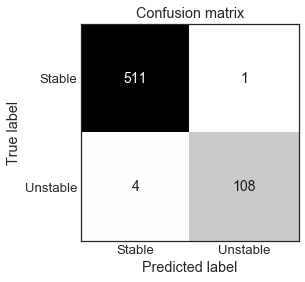

In [16]:
pred = lreg.predict(X_test)
labels = ['Stable', 'Unstable']
# confusion matrix
scores_image = heatmap(metrics.confusion_matrix(y_test, pred), xlabel='Predicted label', 
                       ylabel='True label', xticklabels=labels, yticklabels=labels, 
                       cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
plt.show()

In [17]:
# classification report
print(metrics.classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      Stable       0.99      1.00      1.00       512
    Unstable       0.99      0.96      0.98       112

    accuracy                           0.99       624
   macro avg       0.99      0.98      0.99       624
weighted avg       0.99      0.99      0.99       624



#### GridSearchCV

In [18]:
# Grid-search with cross validation for optimal model hyper-parameters
parameters = {'C':[1., 10., 50., 100., 500., 1000.]}
lreg = GridSearchCV(estimator=LR(multi_class='ovr', solver='newton-cg'), 
                    param_grid=parameters, cv=3, scoring='f1',  # notice the "scoring" method!
                    refit=True, n_jobs=-1, iid=False)
# In this case GridSearchCV uses StratifiedKFold (with cv=3 folds) when
# the estimator is a classifier and y is either binary or multiclass!
lreg.fit(X_train, y_train)
# Best value of hyper-parameter "C"
best_c = lreg.best_params_['C']
print('Best value: C = {:g}'.format(best_c))

Best value: C = 50


In [19]:
# Average classification accuracy with cross validation
scores = cross_val_score(LR(C=best_c, multi_class='ovr', solver='newton-cg'), 
                         X_train, y_train, cv=3, scoring='f1')  # it doesn't return a model!
print('Score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Score using 3-fold CV: 0.983391 +/- 0.00523203


### Principal components analysis

In [20]:
# Let's first reduce all 276 features in the dataset down to 3 principal components.
pca = PCA(n_components=3)
X3_train = pca.fit_transform(X_train)
X3_test = pca.transform(X_test)
idx_stable = y_test==0

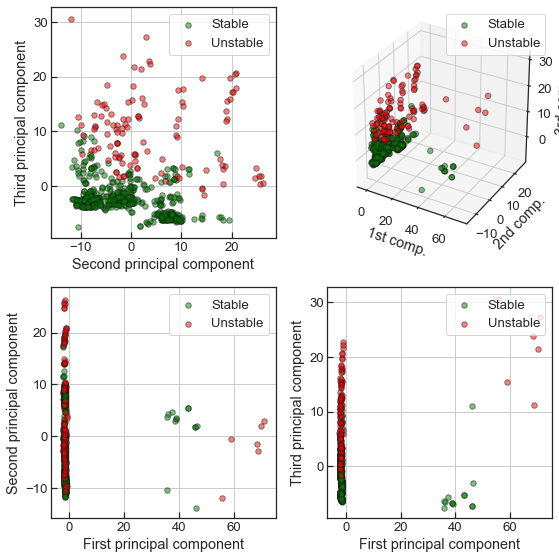

In [21]:
# Let's see what it looks like
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax0 = fig.add_subplot(221)
ax0.scatter(X3_test[idx_stable,1], X3_test[idx_stable,2], 
              s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax0.scatter(X3_test[~idx_stable,1], X3_test[~idx_stable,2], 
              s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax0.legend(loc='upper right')
ax0.set_xlabel('Second principal component')
ax0.set_ylabel('Third principal component')
ax0.grid()
ax1 = fig.add_subplot(222, projection='3d')
ax1.scatter(X3_test[idx_stable,0], X3_test[idx_stable,1], X3_test[idx_stable,2], 
              s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax1.scatter(X3_test[~idx_stable,0], X3_test[~idx_stable,1], X3_test[~idx_stable,2],
              s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax1.legend(loc='upper right')
ax1.set_xlabel('1st comp.')
ax1.set_ylabel('2nd comp.')
ax1.set_zlabel('3rd comp.')
ax0 = fig.add_subplot(223)
ax0.scatter(X3_test[idx_stable,0], X3_test[idx_stable,1], 
              s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax0.scatter(X3_test[~idx_stable,0], X3_test[~idx_stable,1], 
              s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax0.legend(loc='upper right')
ax0.set_xlabel('First principal component')
ax0.set_ylabel('Second principal component')
ax0.grid()
ax0 = fig.add_subplot(224)
ax0.scatter(X3_test[idx_stable,0], X3_test[idx_stable,2], 
              s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax0.scatter(X3_test[~idx_stable,0], X3_test[~idx_stable,2], 
              s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax0.legend(loc='upper right')
ax0.set_xlabel('First principal component')
ax0.set_ylabel('Third principal component')
ax0.grid()
fig.tight_layout()
plt.show()

In [22]:
# Average LR accuracy with only three principal components as features
scores = cross_val_score(LR(C=best_c, multi_class='ovr', solver='newton-cg'), 
                         X3_train, y_train, cv=3, scoring='f1')
print('Score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Score using 3-fold CV: 0.811476 +/- 0.0108624


#### Feature selection with Pipeline and GridSearch

In [23]:
# Optimize the number of features and the classifier's hyper-parameters 
# at the same time, using pipline and grid search with cross-validation
pca = PCA()  # do NOT set "n_components" here!
logreg = LR(multi_class='ovr', solver='newton-cg')  # multinomial classification!
pipe = Pipeline([('pca',pca), ('logreg',logreg)])
param_grid = {'pca__n_components': [10, 20, 30, 50, 100],   # PCA
              'logreg__C': [10., 50., 100., 500.]}      # LogisticRegression
grid_pipe = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, 
                         scoring='f1', refit=True, n_jobs=-1, iid=False)
grid_pipe.fit(X_train, y_train)
print('Best parameter (CV score = {:0.3f}):'.format(grid_pipe.best_score_))
print(grid_pipe.best_params_)

Best parameter (CV score = 0.983):
{'logreg__C': 50.0, 'pca__n_components': 100}


In [24]:
# Predict probability on test data
y_lr = grid_pipe.predict_proba(X_test)
y_t['logreg'] = y_lr.argmax(axis=1)

In [25]:
y_t.head()

,Stability,logreg
1707,0,0
1543,0,0
3116,1,1
26,0,0
356,0,0


### Support Vector Machine

In [26]:
parameters ={'C':[1., 10., 100., 500., 1000.],
             'gamma':[0.0001, 0.001, 0.01, 0.1, 1.]}
svc = GridSearchCV(estimator=svm.SVC(kernel='rbf', probability=True), 
                   param_grid=parameters, cv=3,
                   scoring='f1', refit=True, n_jobs=-1, iid=False)
svc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=-1,
             param_grid={'C': [1.0, 10.0, 100.0, 500.0, 1000.0],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [27]:
# Best model parameters
best_parameters = svc.best_params_
print("Best parameters from GridSearch: {}".format(svc.best_params_))

Best parameters from GridSearch: {'C': 100.0, 'gamma': 0.1}


In [28]:
scores = cross_val_score(svm.SVC(**best_parameters), X_train, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.989667 +/- 0.00147759


In [29]:
results = pd.DataFrame(svc.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(parameters['C']), len(parameters['gamma']))

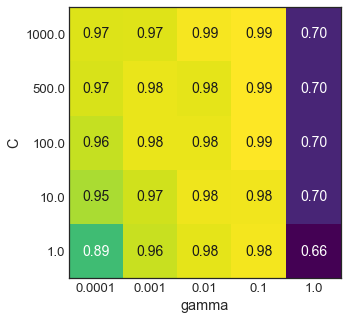

In [30]:
fig, ax = plt.subplots(figsize=(5,5))
heatmap(scores, xlabel='gamma', xticklabels=parameters['gamma'], 
        ylabel='C', yticklabels=parameters['C'], cmap="viridis", ax=ax)
plt.show()

#### RandomizedSearchCV

In [31]:
parameters = {'C':stats.expon(scale=100), 'gamma':stats.expon(scale=.1)}
svc2 = RandomizedSearchCV(estimator=svm.SVC(kernel='rbf', probability=True), 
                          param_distributions=parameters, cv=3, n_iter=50,  # 50 iterations!
                          scoring='f1',  # notice the scoring method!
                          refit=True, n_jobs=-1, iid=False)
svc2.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=True,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid=False, n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f98a40e4dd8>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f98a40e4358>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [32]:
# Best model parameters
best_parameters = svc2.best_params_
print("Best parameters from RandomSearch: {}".format(svc2.best_params_))

Best parameters from RandomSearch: {'C': 184.39987834136727, 'gamma': 0.041415870287279846}


In [33]:
scores = cross_val_score(svm.SVC(**best_parameters), X_train, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.99068 +/- 0.00509513


In [34]:
y_svc2 = svc2.predict_proba(X_test)
y_t['svc'] = y_svc2.argmax(axis=1)

#### Precision-Recall Tradeoff

In [35]:
y_probas = cross_val_predict(svm.SVC(**best_parameters, probability=True), 
                             X_train, y_train, cv=3, method='predict_proba')
y_scores = y_probas[:,1]  # score == probability of positive class

In [36]:
precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, y_scores)

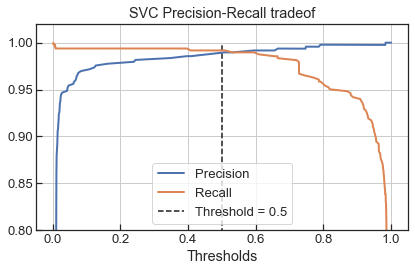

In [37]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_title('SVC Precision-Recall tradeof')
ax.plot(thresholds, precisions[:-1], lw=2, label='Precision')
ax.plot(thresholds, recalls[:-1], lw=2, label='Recall')
plt.vlines(0.5, 0, 1, linestyles='--', label='Threshold = 0.5')
ax.set_xlabel('Thresholds')
ax.legend(loc='best')
ax.set_ylim(bottom=0.8, top=1.02)
ax.grid()
fig.tight_layout()
plt.show()

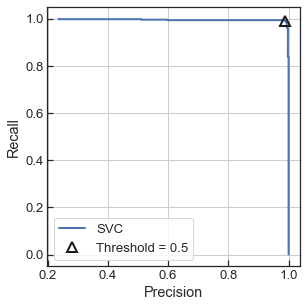

In [38]:
fig, ax = plt.subplots(figsize=(4.5,4.5))
ax.plot(precisions, recalls, lw=2, label='SVC')
default = np.argmin(np.abs(thresholds - 0.5))
ax.plot(precisions[default], recalls[default], '^', c='k', markersize=10, 
        label='Threshold = 0.5', fillstyle='none', mew=2)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.legend(loc='best')
ax.grid()
fig.tight_layout()
plt.show()

In [39]:
# Average precision-recall score
y_test_score = svc2.predict_proba(X_test)[:,1]
average_precision = metrics.average_precision_score(y_test, y_test_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 1.00


In [40]:
# Determine a class from the predicted probability by using 
# the user-specified threshold value (not a default of 0.5)
THRESHOLD = 0.6  # Example
preds = np.where(y_test_score > THRESHOLD, 1, 0)

In [41]:
pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.995192
recall,0.991071
precision,0.982301
roc_auc_score,0.993583


### ExtraTreesClassifier

In [42]:
# ExtraTreesClassifier (ensemble learner) with grid search 
# and cross-validation for hyper-parameters optimisation
parameters = {'n_estimators':[5, 10, 15, 20], 
              'criterion':['gini', 'entropy'], 
              'max_depth':[2, 5, None]}
trees = GridSearchCV(estimator=ExtraTreesClassifier(), param_grid=parameters, 
                     cv=3, scoring='f1', refit=True, n_jobs=-1, iid=False) 
trees.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None,
                                            criterion='gini', max_depth=None,
                                            max_features='auto',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators='warn', n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid=False, n_jobs=-1,
             param_grid={'criterion': ['gini', 'en

In [43]:
# Best model parameters
best_parameters = trees.best_params_
print("Best parameters: {}".format(trees.best_params_))

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 10}


In [44]:
scores = cross_val_score(ExtraTreesClassifier(**best_parameters), X_train, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.985487 +/- 0.00395923


In [45]:
y_trees = trees.predict_proba(X_test)
y_t['tree'] = y_trees.argmax(axis=1)

### RandomForest classifier (ensemble learner)

In [46]:
# RandomForestClassifier (ensemble learner for classification)
parameters = {'n_estimators':[10, 15, 20], 
              'criterion':['gini', 'entropy'],
              'max_features':[4, 'auto'],
              'max_depth':[2, None]}
# grid search and cross-validation for hyper-parameters optimisation
forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, 
                      cv=3, scoring='f1', refit=True, n_jobs=-1, iid=False) 
forest.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [47]:
best_parameters = forest.best_params_
print("Best parameters: {}".format(forest.best_params_))

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'n_estimators': 15}


In [48]:
scores = cross_val_score(RandomForestClassifier(**best_parameters), X_train, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.986628 +/- 0.00284673


In [49]:
y_forest = forest.predict_proba(X_test)
y_t['forest'] = y_forest.argmax(axis=1)

### GradientBoosting classifier with feature importance analysis

In [50]:
# Train & evaluate model performance
def train_and_evaluate(model, X, y, ns=3):
    # k-fold cross validation iterator 
    cv = StratifiedKFold(n_splits=ns, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1')  # scoring='f1'
    print('Average score using {:d}-fold CV: {:g} +/- {:g}'.format(ns, np.mean(scores), np.std(scores)))

In [51]:
# Gradient Boosting Classifier
clf_gb = GradientBoostingClassifier()
train_and_evaluate(clf_gb, X_train, y_train, 3)
clf_gb.fit(X_train, y_train)

Average score using 3-fold CV: 0.98541 +/- 0.00897507


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [52]:
# Feature importance
feature_importance = clf_gb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

In [53]:
# Select top features
TOP = 10
top_features = data.columns.values[sorted_idx][-TOP:][::-1]
print('Most relevant {:d} features according to the GradientBoostingClassifier:'.format(TOP))
print(top_features)

Most relevant 10 features according to the GradientBoostingClassifier:
['IqG7' 'IqG9' 'IqG6' 'VtG5' 'PlvG6' 'PlvG9' 'LAlvG8' 'VtG3' 'IqG8' 'IdG9']


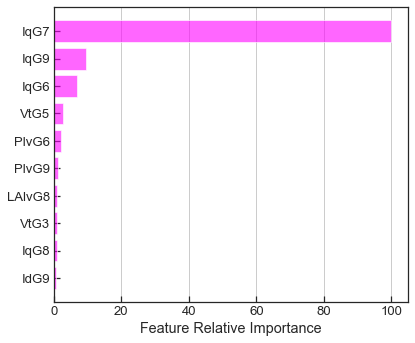

In [54]:
# Plot relative feature importance
fig, ax = plt.subplots(figsize=(6,5))
ax.barh(pos[-TOP:], feature_importance[sorted_idx][-TOP:], align='center', color='magenta', alpha=0.6)
plt.yticks(pos[-TOP:], data.columns[sorted_idx][-TOP:])
ax.set_xlabel('Feature Relative Importance')
ax.grid(which='major', axis='x')
plt.tight_layout()
plt.show()

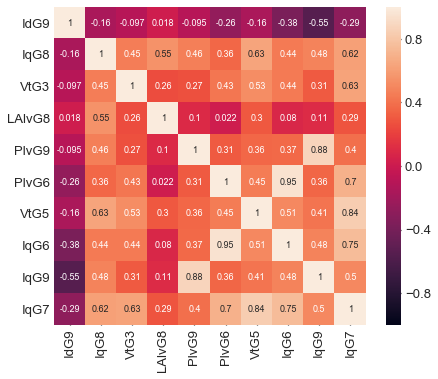

In [55]:
# Correlation matrix of selected features
pearson = data[data.columns[sorted_idx][-TOP:]].corr('pearson')
pearson.iloc[-1][:-1].sort_values()
# Correlation matrix as heatmap (seaborn)
fig, ax = plt.subplots(figsize=(6.5,5.5))
sns.heatmap(pearson, annot=True, annot_kws=dict(size=9), vmin=-1, vmax=1, ax=ax)
plt.tight_layout()
plt.show()

In [56]:
# Predict on new data
y_gb = clf_gb.predict_proba(X_test)
y_t['gbr'] = y_gb.argmax(axis=1)

#### Re-train SVM using only top features from the GradientBoosting classifier

In [57]:
# IMPORTANT: NTOP <= TOP
NTOP = 2  # using only top 2 features!

In [58]:
top_features_index = []
for name in top_features:
    top_features_index.append(data.columns.get_loc(name))

In [59]:
X_train_best = X_train[:,top_features_index[:NTOP]]
X_test_best = X_test[:,top_features_index[:NTOP]]
print(X_train_best.shape)
print(X_test_best.shape)

(2496, 2)
(624, 2)


In [60]:
# Optimize SVM with only TOP features
parameters = {'C':stats.expon(scale=100), 'gamma':stats.expon(scale=.1)}
svc_top = RandomizedSearchCV(estimator=svm.SVC(kernel='rbf', probability=True), 
                             param_distributions=parameters, cv=3, n_iter=100,  # 100 iterations!
                             scoring='f1',  # notice the scoring method!
                             refit=True, n_jobs=-1, iid=False)
svc_top.fit(X_train_best, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=True,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid=False, n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9889fd9da0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9889fd9438>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [61]:
# Best model parameters
best_parameters = svc_top.best_params_
print("Best parameters from RandomSearch: {}".format(svc_top.best_params_))

Best parameters from RandomSearch: {'C': 199.1939164496869, 'gamma': 0.4868335864594562}


In [62]:
scores = cross_val_score(svm.SVC(**best_parameters), X_train_best, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.941861 +/- 0.0078676


#### Graphical visualization of the top two features

In [63]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [64]:
idx_stable = y_test==0

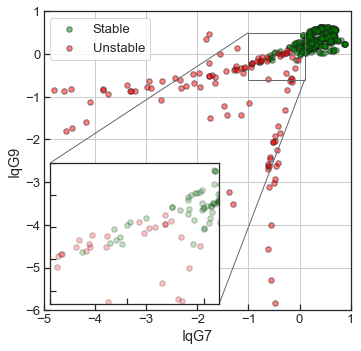

In [65]:
# Ploting data without standard scaler transformer
fig, ax = plt.subplots(figsize=(5.5,5.5))
ax.scatter(X_test_best[idx_stable,0], X_test_best[idx_stable,1], 
           s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax.scatter(X_test_best[~idx_stable,0], X_test_best[~idx_stable,1], 
           s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax.legend(loc='upper left')
ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_xlim(-5,1)
ax.set_ylim(-6,1)
ax.grid()
# Inset figure with a zoomed-in region of interest
axins = zoomed_inset_axes(ax, zoom=3, loc='lower left')
axins.scatter(X_test_best[idx_stable,0], X_test_best[idx_stable,1], 
              s=30, c='green', marker='o', edgecolors='k', alpha=0.25, label='Stable')
axins.scatter(X_test_best[~idx_stable,0], X_test_best[~idx_stable,1], 
              s=30, c='red', marker='o', edgecolors='k', alpha=0.25, label='Unstable')
axins.set_xlim(-1,0.1)
axins.set_ylim(-0.6,0.5)
plt.xticks(visible=False)
plt.yticks(visible=False)
# draw a box of the region of the inset axes in the parent axes 
# and connecting lines between the box and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc='none', ec='dimgrey')
plt.show()

#### Plot decision region for test samples with only top two features (NTOP = 2)

In [66]:
# Axis grid with NTOP = 2
h = 0.1; delta = 0.01
x_min, x_max = X_test_best[:,0].min() - h, X_test_best[:,0].max() + h
y_min, y_max = X_test_best[:,1].min() - h, X_test_best[:,1].max() + h
xx, yy = np.meshgrid(np.arange(x_min, x_max, delta), np.arange(y_min, y_max, delta))
Z = svc_top.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)

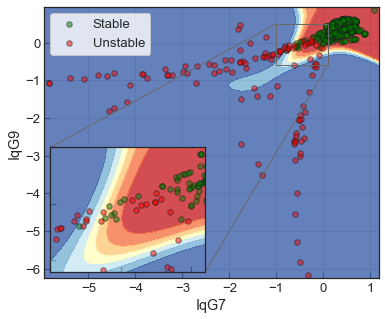

In [67]:
fig, ax = plt.subplots(figsize=(6,5))
ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
ax.scatter(X_test_best[idx_stable,0], X_test_best[idx_stable,1], 
           s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax.scatter(X_test_best[~idx_stable,0], X_test_best[~idx_stable,1], 
           s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax.legend(loc='upper left')
ax.set_xlabel(top_features[0])
ax.set_ylabel(top_features[1])
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.grid()
# Inset figure with a zoomed-in region of interest
axins = zoomed_inset_axes(ax, zoom=3, loc='lower left')
axins.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
axins.scatter(X_test_best[idx_stable,0], X_test_best[idx_stable,1], 
              s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
axins.scatter(X_test_best[~idx_stable,0], X_test_best[~idx_stable,1], 
              s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
axins.set_xlim(-1,0.1)
axins.set_ylim(-0.6,0.5)
plt.xticks(visible=False)
plt.yticks(visible=False)
# draw a box of the region of the inset axes in the parent axes 
# and connecting lines between the box and the inset axes area
mark_inset(ax, axins, loc1=2, loc2=4, fc='none', ec='dimgrey')
plt.show()

### Principal components with best features

In [68]:
# Projecting TOP features using only two principal components
pca = PCA(n_components=2)
X2_train = pca.fit_transform(X_train[:,top_features_index])
X2_test = pca.transform(X_test[:,top_features_index])

<p style="background-color:honeydew;padding:10px;border:2px solid mediumseagreen"><b>Note:</b> All of the TOP features selected previously from the GradientBoostingClassifier are reduced down to the two principal components with PCA(n_components=2). This essentially means that the TOP-dimensional space of original features is projected into the 2D space of principal components. Now, one can easily visualize test cases and novel decision boundary in this new 2D coordinate system of principal components.</p>

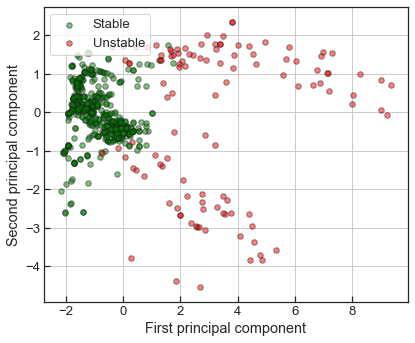

In [69]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(X2_test[idx_stable,0], X2_test[idx_stable,1], 
           s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax.scatter(X2_test[~idx_stable,0], X2_test[~idx_stable,1], 
           s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax.legend(loc='upper left')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.grid()
fig.tight_layout()
plt.show()

#### Train SVM classifier using principal components

In [70]:
# Optimize SVM with only TOP features
parameters = {'C':stats.expon(scale=100), 'gamma':stats.expon(scale=.1)}
svc_pca = RandomizedSearchCV(estimator=svm.SVC(kernel='rbf', probability=True), 
                             param_distributions=parameters, cv=3, n_iter=100,  # 100 iterations!
                             scoring='f1',  # notice the scoring method!
                             refit=True, n_jobs=-1, iid=False)
svc_pca.fit(X2_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                 coef0=0.0, decision_function_shape='ovr',
                                 degree=3, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, probability=True,
                                 random_state=None, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid=False, n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9889eb02b0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9889eb07f0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='f1', verbose=0)

In [71]:
# Best model parameters
best_parameters = svc_pca.best_params_
scores = cross_val_score(svm.SVC(**best_parameters), X2_train, y_train, cv=3, scoring='f1')
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.959364 +/- 0.0116201


In [72]:
h = 0.1; delta = 0.01
x_min, x_max = X2_test[:,0].min() - h, X2_test[:,0].max() + h
y_min, y_max = X2_test[:,1].min() - h, X2_test[:,1].max() + h
xx, yy = np.meshgrid(np.arange(x_min, x_max, delta), np.arange(y_min, y_max, delta))
Z = svc_pca.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
Z = Z.reshape(xx.shape)

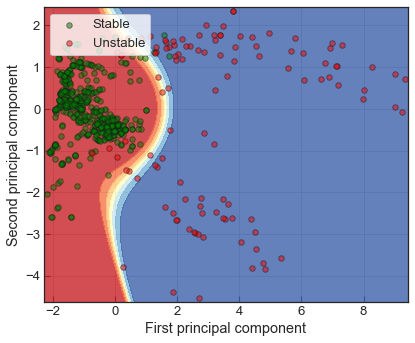

In [73]:
fig, ax = plt.subplots(figsize=(6,5))
ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
ax.scatter(X2_test[idx_stable,0], X2_test[idx_stable,1], 
           s=30, c='green', marker='o', edgecolors='k', alpha=0.5, label='Stable')
ax.scatter(X2_test[~idx_stable,0], X2_test[~idx_stable,1], 
           s=30, c='red', marker='o', edgecolors='k', alpha=0.5, label='Unstable')
ax.legend(loc='upper left')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.grid()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
fig.tight_layout()
plt.show()

## Ensemble models using voting principle

<p style="background-color:honeydew;padding:10px;border:2px solid mediumseagreen"><b>Note:</b> Ensembling consists of pooling together the predictions of a set of different models, to produce better predictions. The key to making ensembling work is the diversity of the set of classifiers. Diversity is what makes ensembling work. For this reason, one should ensemble models that are as good as possible while being <b>as different as possible</b>. This typically means using very different network architectures or even different brands of machine-learning approaches. This is exactly what has been proposed here.</p>

### Soft voting

In [74]:
clf = VotingClassifier(estimators=[('logreg', lreg),     # LogisticRegression
                                   ('svm', svc2),        # SVC
                                   ('forest', forest)],  # RandomForest 
                       weights=[1, 2, 1],  # classifier relative weights
                       voting='soft', n_jobs=-1)
clf = clf.fit(X_train, y_train)  # train with a full set of features

In [75]:
y_clf = clf.predict_proba(X_test)
y_t['vote'] = y_clf.argmax(axis=1)

In [76]:
scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)  # scoring='accuracy'
print('Average score using 3-fold CV: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)))

Average score using 3-fold CV: 0.995192 +/- 0.000981366


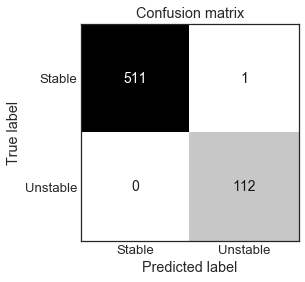

In [77]:
# confusion matrix
scores_image = heatmap(metrics.confusion_matrix(y_test, clf.predict(X_test)), 
                       xlabel='Predicted label', ylabel='True label', 
                       xticklabels=labels, yticklabels=labels, 
                       cmap=plt.cm.gray_r, fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()
plt.show()

#### Predictions using individual classifiers and ensembles

In [78]:
y_t.head(10)

,Stability,logreg,svc,tree,forest,gbr,vote
1707,0,0,0,0,0,0,0
1543,0,0,0,0,0,0,0
3116,1,1,1,1,1,1,1
26,0,0,0,0,0,0,0
356,0,0,0,0,0,0,0
2397,0,0,0,0,0,0,0
2282,0,0,0,0,0,0,0
1762,0,0,0,0,0,0,0
387,0,0,0,0,0,0,0
1646,0,0,0,0,0,0,0


In [79]:
import sys, IPython, sklearn, scipy, matplotlib
print("Notebook createad with:\
      \nPython {:s}\nIPython {:s}\nScikit-learn {:s}\nPandas {:s}\nNumpy {:s}\nScipy {:s}\nMatplotlib {:s}"\
      .format(sys.version[:5], IPython.__version__, sklearn.__version__, pd.__version__, np.__version__, 
              scipy.__version__, matplotlib.__version__))

Notebook createad with:      
Python 3.7.3
IPython 7.7.0
Scikit-learn 0.21.2
Pandas 0.25.0
Numpy 1.16.4
Scipy 1.3.1
Matplotlib 3.1.0
